<h1>데이터 분석:</h1>

torchvision module에서 제공하는 FashionMNIST를 활용해야 합니다

이미지 데이터의 형태와 클래스 레이블을 시각적으로 탐색하고 분석합니다.

In [2]:
%pip install torchvision
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
#4번 torchvision 문제 생기면


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 47.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
#image transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
#train 데이터셋 로드
train_data = datasets.FashionMNIST(root='data', 
                                   train=True,
                                   download=True, 
                                   transform=transform                
                                  )
#test 데이터셋 로드
test_data = datasets.FashionMNIST(root='data', 
                                   train=True,
                                   download=True, 
                                   transform=transform                
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



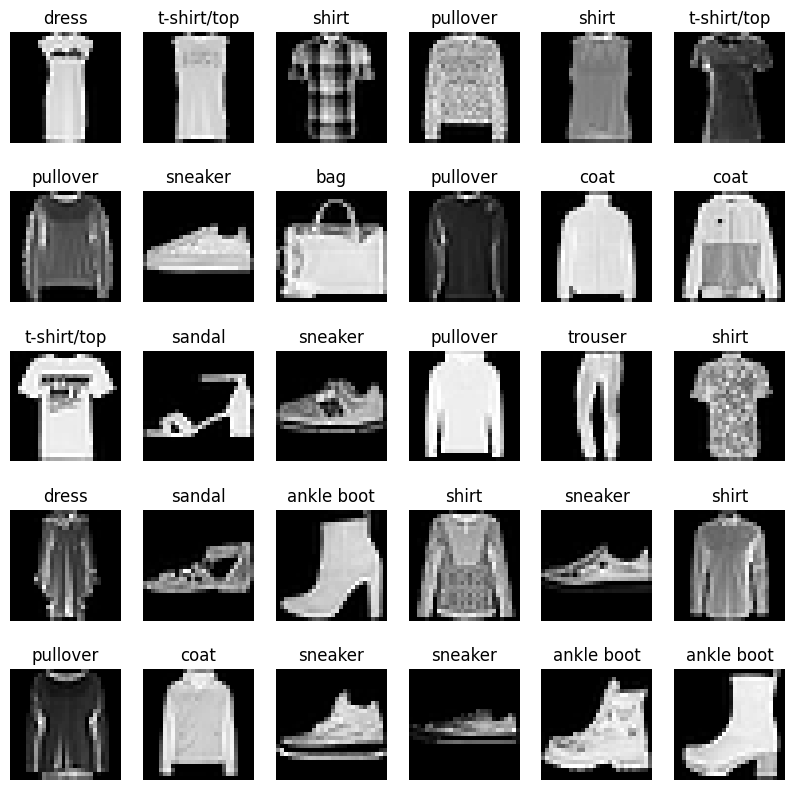

In [5]:
import matplotlib.pyplot as plt
#labels_map을 통해서 시각적으로 분류한사진위에
#라벨을 남기는것으로 이해했습니다
labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

#가로 6개, 세로 5개에 총 30개의 이미지 분류 결과를 시각적으로 표시하게 만들었습니다
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

<h1>모델 구축 및 훈련:</h1>

간단한 CNN 모델을 구축합니다. 모델은 적어도 한 개의 컨볼루션 레이어와 풀링 레이어를 포함해야 합니다.

모델을 컴파일하고, 적절한 손실 함수와 최적화 알고리즘을 선택합니다.

훈련 데이터를 사용하여 모델을 훈련시키고, 훈련 과정에서의 손실과 정확도를 모니터링합니다.

<h4>링크말고 새로 설정</h4>
fashionmnist에서 데이터셋 로드로 바꾸고 그래프에 val을 test로 변경


In [6]:
 
# Script file to hide implementation details for PyTorch computer vision module

import builtins
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import zipfile 

default_device = 'cuda' if torch.cuda.is_available() else 'cpu'


#여기서 FashionMNIST 데이터셋 로드(수업자료 변경 o)(MNIST에서 FasionMNIST)
def load_mnist(batch_size=64):
    builtins.data_train = torchvision.datasets.FashionMNIST('./data',
        download=True,
        train=True,
        transform=ToTensor())
    builtins.data_test = torchvision.datasets.FashionMNIST('./data',
        download=True,
        train=False,
        transform=ToTensor())
    #배치 사이드 64(수업자료 변경 x)
    builtins.train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
    builtins.test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)
    
    
#    
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = net(features.to(default_device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
        
    return total_loss.item()/count, acc.item()/count


def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

#(수업자료 변경 O)
#val_loss->test_loss
#val_acc->test_acc
def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Test acc={va:.3f}, Train loss={tl:.3f}, Test loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['test_loss'].append(vl)
        res['test_acc'].append(va)
    return res

def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(default_device)
            optimizer.zero_grad()
            out = net(features.to(default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, Test acc = {}, Test loss = {}".format(epoch,va,vl))

#(수업자료 변경 O)
#val_acc->test_acc
#val_loss->test_loss
def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['test_acc'], label='Testing acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['test_loss'], label='Testing loss')
    plt.legend()

def plot_convolution(t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = data_train[i][0]
            ax[0][i].imshow(im[0])
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0])
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        #plt.tight_layout()
        plt.show()
        
def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])


def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return True
    except:
        return False
    
def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image: {}".format(fn))
            os.remove(fn)


def common_transform():
    std_normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    trans = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(), 
            std_normalize])
    return trans

def load_cats_dogs_dataset():
    if not os.path.exists('data/PetImages'):
        with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
            zip_ref.extractall('data')

    check_image_dir('data/PetImages/Cat/*.jpg')
    check_image_dir('data/PetImages/Dog/*.jpg')

    dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=common_transform())
    trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    testloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    return dataset, trainloader, testloader


In [7]:

%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
#import pytorchcv
#from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128) 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 11.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


<h1>컨볼루션레이어만 사용한 모델</h1>

In [8]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트


class OneConv(nn.Module):
    def __init__(self): 
        super(OneConv, self).__init__() 
        # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) 
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        
        #여기서 5184라는 숫자는 24*24*9로, 9개의 아웃채널에서 28,28픽셀로 받게되면 24,24로전환됩니다 
        # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당
        self.fc = nn.Linear(5184,10) 

    def forward(self, x):
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


In [9]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5):
    # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    # 수업시간에 깃헙에서는 그래픽카드가 지원되지않아 cpu가 사용된다고 들었기에 cpu가 사용되는걸로 이해했습니다.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}#, 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고,
    # 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            ##
            ##이거는 train하는 모델
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
            for data, target in train_loader: 
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
            # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트    
                loss = criterion(output, target) 
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            #백분율로 변환
            train_acc = 100. * train_correct / train_total

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            

            ##
            ##이게 test하는 모델
            model.eval()
            # 0 0 0 으로 초기화
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



컨볼루션레이어모델을 사용하여 그 결과를 처리

위에서 net = OneConv() 을 통해 net 설정.

Epoch 1/5: Train Loss: 0.0042, Train Acc: 81.42%, Test Loss: 0.0034, Test Acc: 84.41%
Epoch 2/5: Train Loss: 0.0030, Train Acc: 86.54%, Test Loss: 0.0032, Test Acc: 85.79%
Epoch 3/5: Train Loss: 0.0027, Train Acc: 87.70%, Test Loss: 0.0031, Test Acc: 86.01%
Epoch 4/5: Train Loss: 0.0025, Train Acc: 88.45%, Test Loss: 0.0030, Test Acc: 86.68%
Epoch 5/5: Train Loss: 0.0024, Train Acc: 89.05%, Test Loss: 0.0028, Test Acc: 87.05%


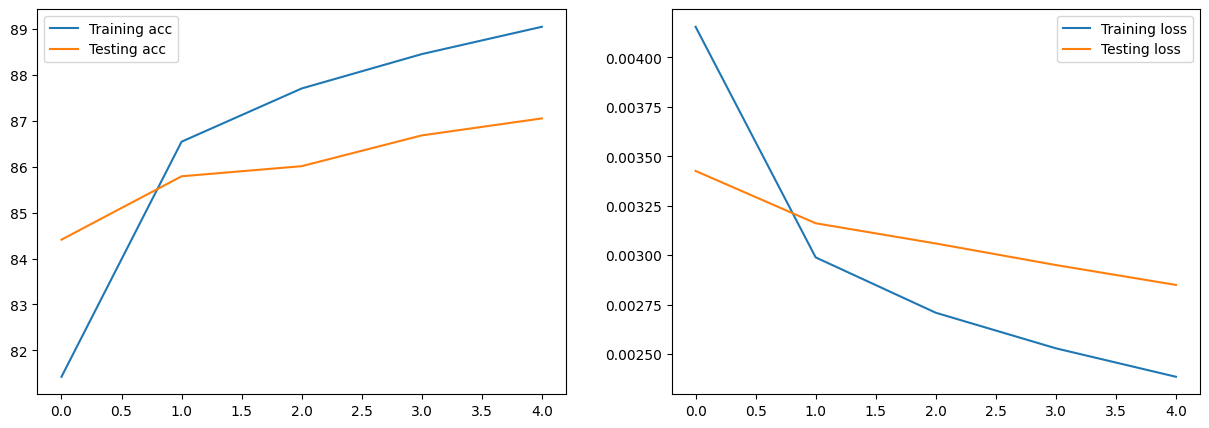

In [10]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 
# 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net,train_loader,test_loader,epochs=5)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

<h2>한개의 컨볼루션 레이어만사용한 모델 결과 모니터링</h2>

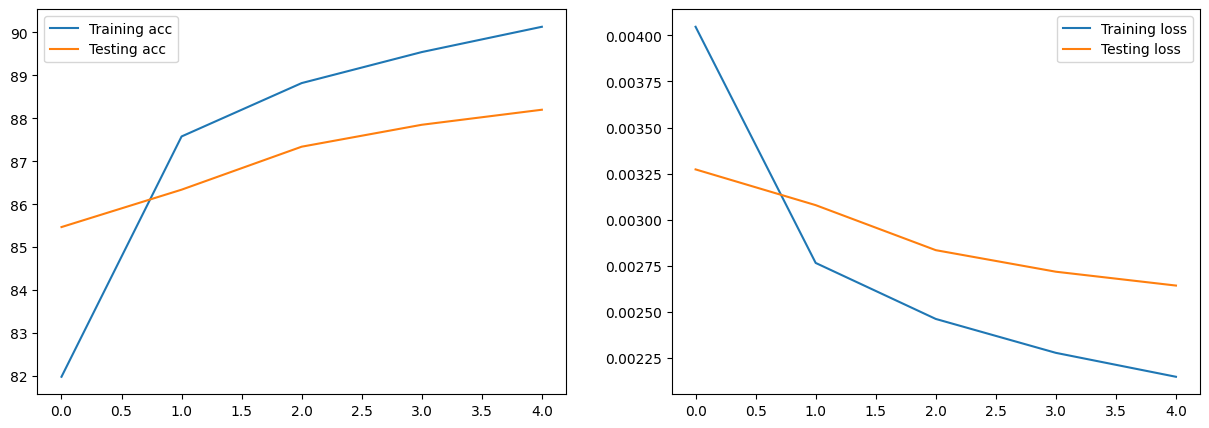

첫번째      훈련 정확도 : 81.99% / 테스트 정확도: 85.47%

두번째      훈련 정확도 : 87.58% / 테스트 정확도: 86.34%

세번째      훈련 정확도 : 88.82% / 테스트 정확도: 87.34%

네번째      훈련 정확도 : 89.54% / 테스트 정확도: 87.85%

다섯번째    훈련 정확도 : 90.13% / 테스트 정확도: 88.20%입니다

<h1>풀링 레이어 추가</h1>
컨볼루션레이어와 풀링레이어 각각 하나씩 설정하여 모델 정의

In [11]:
import torch.nn as nn
%pip install torchsummary
from torchsummary import summary 
class OneConv2(nn.Module):
    def __init__(self):
        super(OneConv2, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5,5))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        #컨볼루션레이어 아웃풋이  24, 24이기 때문에
        #풀링을 통하여 /2를 통해 크기를 12, 12로 맞추었습니다.
        self.fc = nn.Linear(9*12*12,10)

    def forward(self, x):
        if x.dim() == 5 and x.size(2) == 1:
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x))
        x = self.pool(x)  # 컨볼루션 레이어 다음에 풀링 레이어를 적용
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim=1)

        return x


# Create an instance of the network
#net 새로 설정.
net = OneConv2()

summary(net,input_size=(1,1,28,28)) 

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
         MaxPool2d-2            [-1, 9, 12, 12]               0
           Flatten-3                 [-1, 1296]               0
            Linear-4                   [-1, 10]          12,970
Total params: 13,204
Trainable params: 13,204
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.05
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [12]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch 
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5):
    # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    # 수업시간에 깃헙에서는 그래픽카드가 지원되지않아 cpu가 사용됨
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    criterion = torch.nn.CrossEntropyLoss() 
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}#, 'val_acc': [], 'val_loss': []}
    
    try:
        for epoch in range(epochs):
            ##
            ##이거는 train하는 모델
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: 
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
            # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트    
                loss = criterion(output, target) 
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            

            ##
            ##이게 test하는 모델
            model.eval()
            # 0 0 0 으로 초기화
            test_loss, test_correct, test_total = 0, 0, 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



<h1>한 개의 컨볼루션 레이어와 풀링 레이어를 포함한 모델</h1>
훈련 데이터를 사용하여 모델을 훈련시키고, 훈련 과정에서의 손실과 정확도를 모니터링합니다.

Epoch 1/5: Train Loss: 0.0049, Train Acc: 78.98%, Test Loss: 0.0037, Test Acc: 82.98%
Epoch 2/5: Train Loss: 0.0033, Train Acc: 85.46%, Test Loss: 0.0033, Test Acc: 85.24%
Epoch 3/5: Train Loss: 0.0030, Train Acc: 86.64%, Test Loss: 0.0032, Test Acc: 85.94%
Epoch 4/5: Train Loss: 0.0028, Train Acc: 87.37%, Test Loss: 0.0031, Test Acc: 86.47%
Epoch 5/5: Train Loss: 0.0027, Train Acc: 87.89%, Test Loss: 0.0030, Test Acc: 86.70%


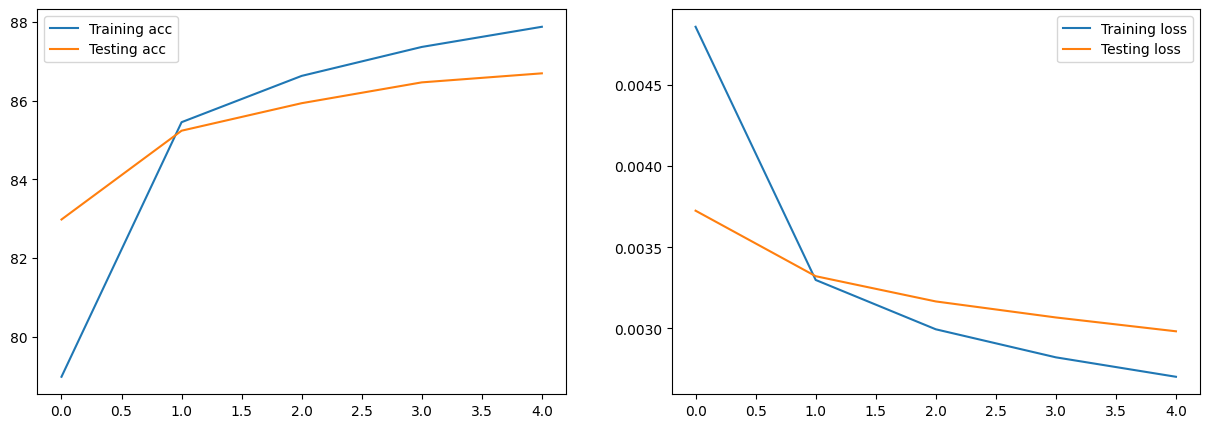

In [13]:
#여기서 net = OneConv2
#위에서 maxpool을 추가로 사용하여 정의하였습니다
hist2 = train(net,train_loader,test_loader,epochs=5)

if hist2 is None:
    print("Training did not return any history.")
else:
    plot_results(hist2)

<h2>한개의 컨볼루션 레이어 이후에 풀링레이어를 사용한 모델 결과 모니터링</h2>

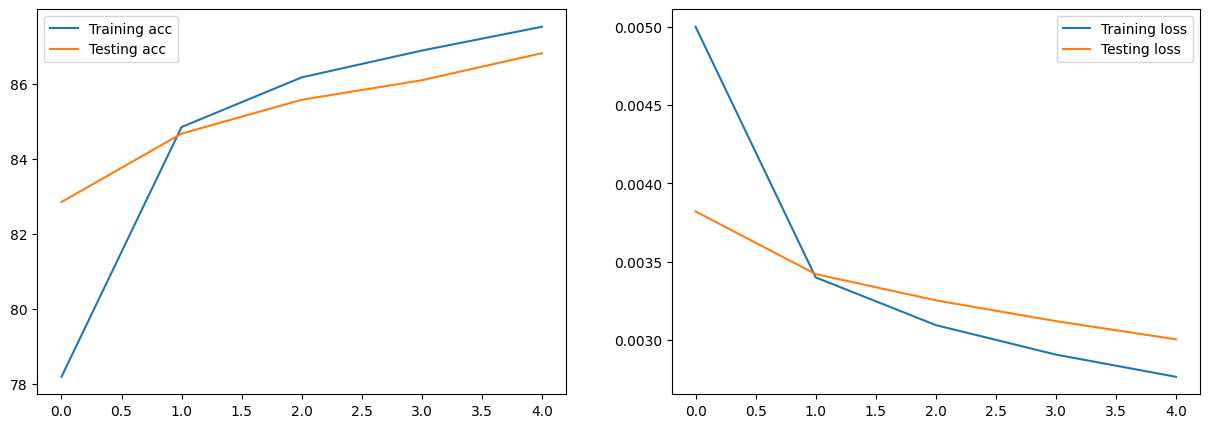

첫번째      훈련 정확도 : 78.20% / 테스트 정확도: 82.85%

두번째      훈련 정확도 : 84.84% / 테스트 정확도: 84.67%

세번째      훈련 정확도 : 86.17% / 테스트 정확도: 85.57%

네번째      훈련 정확도 : 86.88% / 테스트 정확도: 86.09%

다섯번째    훈련 정확도 : 87.51% / 테스트 정확도: 86.81%입니다

<h1>모델 평가 및 결과 분석:</h1>
테스트 데이터셋을 사용하여 모델을 평가하고, 최종 정확도를 보고합니다.

잘못 분류된 이미지들을 분석하고, 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별합니다.

<h3>잘못 분류된 이미지 분석</h3>
맞으면 파랑색, 틀리면 빨간색으로 표시합니다

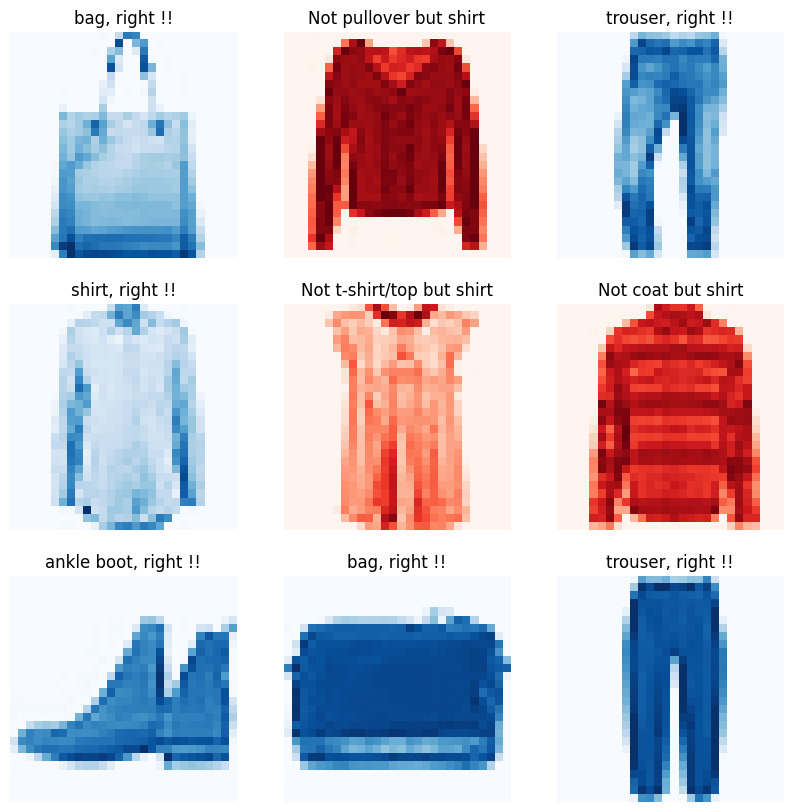

In [14]:
labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}
columns = 3
rows = 3
fig = plt.figure(figsize=(10,10))
model = net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device) # 모델을 해당 장치로 이동

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!')
        cmap = 'Blues'
    else:
        plt.title('Not ' + pred + ' but ' +  label)
        cmap = 'Reds'
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show()

<h3>가장 많이 틀린 항목</h3>
1000개를 돌아보면서 가장 많이 틀리는 항목을 찾아봅니다.

In [17]:
#틀린것을 표시할 배열
incorrect_result_list=[0,0,0,0,0,0,0,0,0,0]
#총 갯수를 표시할 배열
total_result_list = [0,0,0,0,0,0,0,0,0,0]

#총 1000개를 분류
rows = 100
columns =10
model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
 
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    #예측한 결과
    pred = labels_map[argmax.item()]
    #실제 결과
    label = labels_map[test_data[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    #총 갯수를 표시
    total_result_list[test_data[data_idx][1]]+=1
    #틀렸을 경우 해당 인덱스에 표시   
    if pred != label:
        incorrect_result_list[test_data[data_idx][1]]+=1

#틀린 갯수 표시
sum =0
print('틀린 항목당 갯수')
for x in range (10):
    sum += total_result_list[x]
    print(labels_map[x],":",incorrect_result_list[x])
print('total : ',sum)
print('-'*50)



#틀린 비율 표시
most = 0
most_idx=0
for x in range(10):
    print(labels_map[x],':',incorrect_result_list[x]/sum,'%','(',incorrect_result_list[x],'/',total_result_list[x],')')
    if incorrect_result_list[x]/sum >= most:
        most = incorrect_result_list[x]/sum
        most_idx = x
print('가장 많이 틀린 비율의 항목 : ',labels_map[most_idx])


틀린 항목당 갯수
t-shirt/top : 8
trouser : 3
pullover : 15
dress : 10
coat : 12
sandal : 2
shirt : 46
sneaker : 8
bag : 3
ankle boot : 1
total :  1000
--------------------------------------------------
t-shirt/top : 0.008 % ( 8 / 106 )
trouser : 0.003 % ( 3 / 98 )
pullover : 0.015 % ( 15 / 101 )
dress : 0.01 % ( 10 / 111 )
coat : 0.012 % ( 12 / 100 )
sandal : 0.002 % ( 2 / 103 )
shirt : 0.046 % ( 46 / 89 )
sneaker : 0.008 % ( 8 / 95 )
bag : 0.003 % ( 3 / 102 )
ankle boot : 0.001 % ( 1 / 95 )
가장 많이 틀린 비율의 항목 :  shirt
